In [63]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import datetime as dt
from adjdatatools.preprocessing import AdjustedScaler

from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load data

## Base

### Base dataset

In [2]:
df_base = pd.read_csv("datasets/base.csv", index_col=0)
df_base.head()

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   

               63         64          65        66         67          68  \
Id                                                                          
0-base  38.800827 -151.76218  -74.389090  63.66634  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.20211  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.56618  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.20289 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.76632  -2.505783   65.315285   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  

[5 rows x 72 columns]

In [3]:
df_base.shape

(2918139, 72)

In [4]:
df_base.describe()

0             1             2             3             4  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -8.622947e+01  8.080077e+00 -4.458080e+01 -1.466350e+02  1.113166e+02   
std    2.489132e+01  4.953387e+00  3.863166e+01  1.984480e+01  4.634809e+01   
min   -1.994687e+02 -1.391461e+01 -2.400734e+02 -2.326671e+02 -1.055830e+02   
25%   -1.030654e+02  4.708491e+00 -6.955949e+01 -1.599051e+02  8.050795e+01   
50%   -8.623150e+01  8.038950e+00 -4.381661e+01 -1.467768e+02  1.118730e+02   
75%   -6.925658e+01  1.147007e+01 -1.962527e+01 -1.333277e+02  1.423743e+02   
max    2.151555e+01  2.993721e+01  1.609372e+02 -5.137478e+01  3.196645e+02   

                  5             6             7             8             9  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -7.199138e+01 -3.922239e+02  2.035283e+01  1.236842e+02  1.244581e+02   
std    2.818607e+01  2.716550e+02  6.421638e+01  6.356109e+00  6.443058e+01   
min   -2.110086e+02 -7.914699e+02 -3.018597e+02  9.315305e+01 -1.738719e+02   
25%   -9.137994e+01 -6.293318e+02 -2.222147e+01  1.194840e+02  8.176751e+01   
50%   -7.192230e+01 -4.222016e+02  2.080477e+01  1.238923e+02  1.234977e+02   
75%   -5.244111e+01 -1.566686e+02  6.391821e+01  1.279705e+02  1.672206e+02   
max    5.880624e+01  1.096325e+02  3.412282e+02  1.522612e+02  4.275421e+02   

       ...            62            63            64            65  \
count  ...  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   ... -7.902286e+01  3.329735e+01 -1.547962e+02  1.415132e+01   
std    ...  3.045642e+01  2.888603e+01  4.122929e+01  9.895115e+01   
min    ... -2.205662e+02 -8.850774e+01 -3.539028e+02 -1.575944e+02   
25%    ... -9.876390e+01  1.698862e+01 -1.807799e+02 -7.130038e+01   
50%    ... -7.848812e+01  3.471502e+01 -1.539773e+02  1.382693e+01   
75%    ... -5.853355e+01  5.216429e+01 -1.273405e+02  9.966753e+01   
max    ...  6.017411e+01  1.541678e+02  2.436099e+01  1.850981e+02   

                 66            67            68            69            70  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   6.779167e+01  2.354490e+01  7.495930e+01  1.155667e+02 -7.993390e+02   
std    1.823356e+00  5.534224e+01  6.134500e+01  2.117518e+01  3.854131e+02   
min    5.950944e+01 -2.331382e+02 -2.036016e+02  1.572448e+01 -1.297931e+03   
25%    6.658096e+01 -1.251624e+01  3.377574e+01  1.016867e+02 -1.074465e+03   
50%    6.781458e+01  2.341649e+01  7.492997e+01  1.160244e+02 -1.074465e+03   
75%    6.902666e+01  5.975511e+01  1.158760e+02  1.295524e+02 -5.057445e+02   
max    7.571203e+01  3.148988e+02  3.395738e+02  2.147063e+02  9.877081e+01   

                 71  
count  2.918139e+06  
mean  -4.779125e+01  
std    4.174802e+01  
min   -2.267801e+02  
25%   -7.566641e+01  
50%   -4.859196e+01  
75%   -1.971424e+01  
max    1.269732e+02  

[8 rows x 72 columns]

# train

In [5]:
df_train = pd.read_csv("datasets/train.csv", index_col=0)
df_train.head()

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9  ...         63  \
Id                                                      ...              
0-query -347.360606  38.307602  109.085560   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.915900  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607820  ...  78.039764   
3-query -775.150134  79.186520  124.003100  242.650650  ...  44.515266   
4-query -321.317964  45.984676  125.941284  103.392670  ...  45.028910   

                64          65         66          67          68          69  \
Id                                                                              
0-query -155.80257 -101.965943  65.903790   34.457500   62.642094  134.763600   
1-query -151.69771   -1.638704  68.170876   25.096191   89.974976  130.589630   
2-query -169.14620   82.144186  66.008220   18.400496  212.409730  121.931470   
3-query -145.41675   93.990981  64.131350  106.061920   83.178760  118.277725   
4-query -196.09207 -117.626337  66.926220   42.456170   77.621765   92.479930   

                  70         71        Target  
Id                                             
0-query  -415.750254 -25.958572   675816-base  
1-query -1035.092211 -51.276833   366656-base  
2-query -1074.464888 -22.547178  1447819-base  
3-query -1074.464888 -19.902788  1472602-base  
4-query -1074.464888 -21.149351   717819-base  

[5 rows x 73 columns]

In [6]:
df_train.describe()

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -85.328679       7.664345     -43.667046    -146.118630   
std        25.803845       4.955651      39.111064      20.434841   
min      -186.280270     -11.560507    -224.896060    -223.307220   
25%      -103.309147       4.313784     -69.494487    -160.028520   
50%       -85.273695       7.652854     -42.830246    -146.067445   
75%       -67.330810      10.981191     -17.713690    -132.277745   
max        14.585236      28.917845     128.108460     -60.751625   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      111.770592     -73.178792    -440.615118      21.231588   
std        47.700958      28.718853     279.017550      65.985214   
min       -93.272020    -184.962450    -791.469482    -278.582820   
25%        79.474322     -92.834080    -738.536868     -22.131764   
50%       112.260100     -73.364420    -511.837758      22.278989   
75%       143.760830     -53.699612    -201.116578      65.899595   
max       301.363600      51.849710     109.625188     288.171840   

                   8              9  ...             62             63  \
count  100000.000000  100000.000000  ...  100000.000000  100000.000000   
mean      123.067891     126.120201  ...     -81.145553      36.898233   
std         6.492081      64.912752  ...      30.675871      25.357686   
min        94.831150    -142.156950  ...    -210.059310     -60.779335   
25%       118.674642      82.545028  ...    -101.504830      19.774804   
50%       123.087540     125.963340  ...     -80.859640      36.711365   
75%       127.541802     169.701005  ...     -60.492451      53.919520   
max       149.356200     392.827150  ...      47.733450     145.667130   

                  64             65             66             67  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean     -152.223082      14.001695      67.799560      23.029277   
std        41.020285      99.079597       1.838012      55.470761   
min      -317.831670    -157.590189      60.668890    -203.746380   
25%      -178.929470     -71.745018      66.560655     -14.144571   
50%      -151.576985      14.072663      67.813585      23.441363   
75%      -124.436974     100.011024      69.058750      59.941065   
max        11.907364     185.095137      74.779884     266.493320   

                  68             69             70             71  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       73.412076     115.189717    -709.761548     -48.505704  
std        62.203132      21.582238     405.961084      41.215124  
min      -181.973820      22.598862   -1297.871984    -209.935760  
25%        31.685548     100.589324   -1074.464888     -76.478591  
50%        72.880192     115.236635    -808.801696     -48.700929  
75%       114.469224     129.791085    -357.087323     -20.487869  
max       319.867520     201.761260      98.768233     126.191790  

[8 rows x 72 columns]

In [7]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

# validation

In [8]:
df_validation = pd.read_csv("datasets/validation.csv", index_col=0)
df_validation.head()

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  ...  \
Id                                                                        ...   
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750  ...   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998  ...   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320  ...   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730  ...   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914  ...   

                     62         63         64          65        66  \
Id                                                                    
100000-query  -75.51302  52.830902 -143.43945   59.051935  69.28224   
100001-query  -79.44183  29.185436 -168.60590  -82.872443  70.76560   
100002-query -134.79541  37.368730 -159.66231 -119.232725  67.71044   
100003-query  -77.23611  44.100494 -132.53012 -106.318982  70.88396   
100004-query -123.77025  45.635944 -134.25893   13.735359  70.61763   

                     67         68          69           70          71  
Id                                                                       
100000-query  61.927513  111.59253  115.140656 -1099.130485 -117.079360  
100001-query -65.975950   97.07716  123.391640  -744.442332  -25.009320  
100002-query  86.002060  137.63641  141.081630  -294.052271  -70.969604  
100003-query  23.577892  133.18396  143.252940  -799.363667  -89.392670  
100004-query  15.332115  154.56812  101.700640 -1171.892332 -125.307890  

[5 rows x 72 columns]

In [9]:
df_validation.describe()

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -85.302233       7.669724     -43.842474    -146.119797   
std        25.777321       4.956990      39.138775      20.495541   
min      -190.353330     -11.109877    -217.538420    -220.050890   
25%      -103.231790       4.292425     -69.680916    -160.210287   
50%       -85.296745       7.657888     -43.230835    -146.080365   
75%       -67.422104      10.993900     -17.765821    -132.119278   
max        14.427986      27.409784     134.859800     -57.381890   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      111.635071     -73.273042    -441.396759      21.594242   
std        47.751576      28.515740     279.242585      66.478048   
min       -81.198990    -176.705030    -791.460243    -265.608430   
25%        79.101920     -92.789803    -740.620025     -21.804730   
50%       111.959330     -73.579283    -513.922978      22.138012   
75%       143.903735     -53.861139    -202.572440      66.097697   
max       302.065370      50.255325     109.632035     279.468900   

                   8              9  ...             62             63  \
count  100000.000000  100000.000000  ...  100000.000000  100000.000000   
mean      123.077725     126.001062  ...     -81.129311      36.778882   
std         6.504931      64.981697  ...      30.691590      25.427103   
min        96.218350    -135.667300  ...    -215.152280     -66.265970   
25%       118.657689      82.311205  ...    -101.690472      19.564135   
50%       123.062568     126.083595  ...     -81.027250      36.414150   
75%       127.538967     169.680500  ...     -60.274745      53.888420   
max       151.822560     392.827150  ...      41.390480     141.025270   

                  64             65             66             67  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean     -152.341249      14.397762      67.788892      23.250779   
std        41.246347      98.695231       1.844522      55.403862   
min      -337.632870    -157.593541      60.377728    -210.672800   
25%      -179.115082     -70.420034      66.546130     -13.863008   
50%      -151.426035      14.768218      67.800445      23.508739   
75%      -124.400438      99.803923      69.040832      60.154775   
max        14.602035     185.094333      75.400475     251.288590   

                  68             69             70             71  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       73.114446     115.196935    -709.457021     -48.416276  
std        62.056224      21.493081     405.665764      41.292843  
min      -175.921780      25.271042   -1297.923999    -209.935760  
25%        31.494840     100.538862   -1074.464888     -76.359190  
50%        72.152398     115.280990    -807.029697     -48.670001  
75%       114.317053     129.770215    -358.400478     -20.283335  
max       305.937530     201.599980      98.737079     111.831955  

[8 rows x 72 columns]

# scaling

In [10]:
scaler = AdjustedScaler()

In [11]:
start_time = dt.datetime.now().timestamp()
scaler.fit(df_base)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

165.06713008880615

## df_base

In [12]:
start_time = dt.datetime.now().timestamp()
df_base = scaler.transform(df_base)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

17.84929394721985

In [13]:
df_base = pd.DataFrame(df_base)
df_base.describe()

0             1             2             3             4  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   1.498940e-05  1.526265e-03 -3.853316e-03  1.337988e-03 -2.256659e-03   
std    1.841187e-01  1.838249e-01  1.947921e-01  1.872250e-01  1.879892e-01   
min   -8.376046e-01 -8.147175e-01 -9.895840e-01 -8.103290e-01 -8.820075e-01   
25%   -1.245190e-01 -1.235965e-01 -1.298031e-01 -1.238580e-01 -1.272175e-01   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.255619e-01  1.273320e-01  1.219798e-01  1.268855e-01  1.237140e-01   
max    7.969945e-01  8.126653e-01  1.032429e+00  9.000668e-01  8.428082e-01   

                  5             6             7             8             9  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -4.436146e-04  3.326787e-02 -1.313176e-03 -6.174853e-03  2.826215e-03   
std    1.810143e-01  3.014696e-01  1.865884e-01  1.886778e-01  1.896114e-01   
min   -8.932289e-01 -4.097961e-01 -9.375402e-01 -9.124772e-01 -8.751231e-01   
25%   -1.249593e-01 -2.298631e-01 -1.250179e-01 -1.308571e-01 -1.228069e-01   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.251106e-01  2.946758e-01  1.252712e-01  1.210601e-01  1.286713e-01   
max    8.395544e-01  5.902039e-01  9.310285e-01  8.421175e-01  8.947660e-01   

       ...            62            63            64            65  \
count  ...  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   ... -3.338223e-03 -1.013546e-02 -3.849644e-03  9.466092e-04   
std    ...  1.901305e-01  2.065169e-01  1.938133e-01  2.887462e-01   
min    ... -8.869519e-01 -8.809648e-01 -9.398227e-01 -5.002191e-01   
25%    ... -1.265757e-01 -1.267325e-01 -1.259953e-01 -2.484073e-01   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  1.245705e-01  1.247512e-01  1.252159e-01  2.504887e-01   
max    ...  8.656274e-01  8.540115e-01  8.383438e-01  4.997809e-01   

                 66            67            68            69            70  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -2.353552e-03  4.450192e-04  8.932409e-05 -4.135763e-03  2.314199e-01   
std    1.873111e-01  1.918061e-01  1.868159e-01  1.913262e-01  3.241872e-01   
min   -8.531764e-01 -8.891716e-01 -8.482211e-01 -9.062500e-01 -1.879671e-01   
25%   -1.267283e-01 -1.245363e-01 -1.253283e-01 -1.295475e-01  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.245160e-01  1.259430e-01  1.246944e-01  1.222302e-01  4.783747e-01   
max    8.112954e-01  1.010224e+00  8.059284e-01  8.916301e-01  9.868579e-01   

                 71  
count  2.918139e+06  
mean   3.602236e-03  
std    1.878163e-01  
min   -8.016340e-01  
25%   -1.218027e-01  
50%    0.000000e+00  
75%    1.299153e-01  
max    7.898340e-01  

[8 rows x 72 columns]

## df_train

In [14]:
start_time = dt.datetime.now().timestamp()
df_train = scaler.transform(df_train)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

0.3962569236755371

In [15]:
df_train = pd.DataFrame(df_train)
df_train.describe()

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.006678      -0.013902       0.000754       0.006210   
std         0.190869       0.183909       0.197209       0.192792   
min        -0.740051      -0.727355      -0.913055      -0.722023   
25%        -0.126322      -0.138244      -0.129475      -0.125023   
50%         0.007085      -0.014328       0.004974       0.006692   
75%         0.139807       0.109189       0.131619       0.136791   
max         0.745732       0.774836       0.866896       0.811601   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -0.000415      -0.008069      -0.020434       0.001240   
std         0.193476       0.184436       0.309640       0.191728   
min        -0.832074      -0.725957      -0.409796      -0.869906   
25%        -0.131410      -0.134298      -0.351054      -0.124757   
50%         0.001570      -0.009261      -0.099474       0.004284   
75%         0.129338       0.117028       0.245350       0.131028   
max         0.768579       0.794879       0.590196       0.776867   

                   8              9  ...             62             63  \
count  100000.000000  100000.000000  ...  100000.000000  100000.000000   
mean       -0.024471       0.007718  ...      -0.016590       0.015609   
std         0.192714       0.191030  ...       0.191500       0.181291   
min        -0.862664      -0.781790  ...      -0.821360      -0.682724   
25%        -0.154882      -0.120519  ...      -0.143687      -0.106813   
50%        -0.023887       0.007256  ...      -0.014805       0.014273   
75%         0.108335       0.135971  ...       0.112342       0.137300   
max         0.755884       0.792604  ...       0.787964       0.793237   

                  64             65             66             67  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.008246       0.000510      -0.001543      -0.001342   
std         0.192831       0.289121       0.188817       0.192252   
min        -0.770257      -0.500207      -0.734068      -0.787305   
25%        -0.117297      -0.249705      -0.128814      -0.130180   
50%         0.011283       0.000717      -0.000102       0.000086   
75%         0.138865       0.251491       0.127812       0.126587   
max         0.779801       0.499772       0.715537       0.842460   

                  68             69             70             71  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       -0.004622      -0.007542       0.306767       0.000388  
std         0.189429       0.195004       0.341471       0.185419  
min        -0.782357      -0.844137      -0.187917      -0.725855  
25%        -0.131694      -0.139462       0.000000      -0.125457  
50%        -0.006242      -0.007118       0.223460      -0.000490  
75%         0.120410       0.124387       0.603416       0.126435  
max         0.745916       0.774666       0.986856       0.786318  

[8 rows x 72 columns]

## df_validation

In [16]:
start_time = dt.datetime.now().timestamp()
df_validation = scaler.transform(df_validation)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

0.4107661247253418

In [17]:
df_validation = pd.DataFrame(df_validation)
df_validation.describe()

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.006874      -0.013702      -0.000130       0.006199   
std         0.190672       0.183959       0.197349       0.193364   
min        -0.770179      -0.710631      -0.875956      -0.691301   
25%        -0.125750      -0.139037      -0.130415      -0.126738   
50%         0.006914      -0.014142       0.002954       0.006571   
75%         0.139131       0.109661       0.131356       0.138286   
max         0.744568       0.718870       0.900939       0.843393   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -0.000965      -0.008675      -0.021302       0.002294   
std         0.193682       0.183132       0.309890       0.193160   
min        -0.783105      -0.672927      -0.409785      -0.832208   
25%        -0.132920      -0.134014      -0.353365      -0.123807   
50%         0.000350      -0.010641      -0.101788       0.003874   
75%         0.129918       0.115991       0.243734       0.131604   
max         0.771426       0.784639       0.590203       0.751579   

                   8              9  ...             62             63  \
count  100000.000000  100000.000000  ...  100000.000000  100000.000000   
mean       -0.024179       0.007367  ...      -0.016488       0.014755   
std         0.193095       0.191233  ...       0.191599       0.181788   
min        -0.821485      -0.762691  ...      -0.853154      -0.721950   
25%        -0.155385      -0.121207  ...      -0.144845      -0.108319   
50%        -0.024629       0.007610  ...      -0.015851       0.012148   
75%         0.108251       0.135910  ...       0.113701       0.137078   
max         0.829097       0.792604  ...       0.748367       0.760051   

                  64             65             66             67  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.007691       0.001666      -0.002639      -0.000574   
std         0.193893       0.287999       0.189486       0.192020   
min        -0.863340      -0.500217      -0.763979      -0.811311   
25%        -0.118169      -0.245838      -0.130306      -0.129204   
50%         0.011993       0.002747      -0.001452       0.000320   
75%         0.139037       0.250887       0.125971       0.127328   
max         0.792468       0.499770       0.779290       0.789763   

                  68             69             70             71  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       -0.005529      -0.007477       0.307023       0.000790  
std         0.188982       0.194199       0.341223       0.185769  
min        -0.763927      -0.819993      -0.187961      -0.725855  
25%        -0.132274      -0.139918       0.000000      -0.124919  
50%        -0.008459      -0.006717       0.224951      -0.000351  
75%         0.119947       0.124198       0.602312       0.127355  
max         0.703495       0.773209       0.986830       0.721716  

[8 rows x 72 columns]

# Create index

In [18]:
dims = df_base.shape[1]
# n_cells = round(df_base.shape[0] ** 0.5)
n_cells = 1
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [19]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [20]:
# idx_l2.nprobe = 5000

In [21]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

# train search

In [22]:
start_time = dt.datetime.now().timestamp()
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 100)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

2344.1976079940796

In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

In [24]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el[:10]])

print(100 * acc / len(idx))

58.324


In [24]:
list_of_analysis = []
for target, el, dist in zip(targets.values.tolist(), idx.tolist(), vecs.tolist()):
    row = []
    row.append(target)
    print('target:', target)
    row.append(dist[0])
    
    print('min:', dist[0])
    target_not_found = True
    for r in range(len(el)):
        if target == base_index[el[r]]:
            row.append(dist[r])
            row.append(r)
            
            print('distance', dist[r])
            target_not_found = False
    if target_not_found:
        print('target: - , distance: -')
        row.append(np.nan)
        row.append(np.nan)
        
    print('max:', dist[99])
    row.append(dist[99])
    list_of_analysis.append(row)
    print('---------------------------')
    print()
    


target: 675816-base
min: 0.9355009198188782
distance 0.9355009198188782
max: 1.748189091682434
---------------------------

target: 366656-base
min: 1.0235519409179688
target: - , distance: -
max: 2.5682218074798584
---------------------------

target: 1447819-base
min: 0.8330115079879761
distance 1.6609432697296143
max: 1.6943347454071045
---------------------------

target: 1472602-base
min: 0.9771603345870972
distance 0.9771603345870972
max: 2.568031072616577
---------------------------

target: 717819-base
min: 0.08735231310129166
distance 0.46951064467430115
max: 0.606346845626831
---------------------------

target: 2381316-base
min: 0.32999810576438904
distance 0.32999810576438904
max: 2.338315486907959
---------------------------

target: 773187-base
min: 0.034022022038698196
target: - , distance: -
max: 2.2395806312561035
---------------------------

target: 2488580-base
min: 0.017817014828324318
target: - , distance: -
max: 1.1874713897705078
---------------------------

targ

max: 3.1217544078826904
---------------------------

target: 32109-base
min: 0.8135510087013245
distance 1.2209672927856445
max: 2.1937386989593506
---------------------------

target: 59804-base
min: 0.30845218896865845
distance 0.30845218896865845
max: 2.402721405029297
---------------------------

target: 175553-base
min: 0.8742541074752808
distance 0.8742541074752808
max: 2.724499225616455
---------------------------

target: 362190-base
min: 0.38512012362480164
distance 0.38512012362480164
max: 1.50990891456604
---------------------------

target: 1047264-base
min: 2.160684108734131
distance 2.3404664993286133
max: 2.919147491455078
---------------------------

target: 516059-base
min: 0.7419618368148804
distance 1.0100045204162598
max: 1.417797565460205
---------------------------

target: 2582755-base
min: 1.6781949996948242
distance 1.6781949996948242
max: 3.3703935146331787
---------------------------

target: 3197304-base
min: 0.9317016005516052
distance 0.9564584493637085
ma

target: - , distance: -
max: 2.291290044784546
---------------------------

target: 3295689-base
min: 0.5296096801757812
target: - , distance: -
max: 1.6761693954467773
---------------------------

target: 2073276-base
min: 1.4156320095062256
distance 2.076390027999878
max: 2.5039491653442383
---------------------------

target: 405088-base
min: 0.2764166593551636
distance 0.2764166593551636
max: 2.369548797607422
---------------------------

target: 1494814-base
min: 0.9125982522964478
target: - , distance: -
max: 1.438085913658142
---------------------------

target: 476683-base
min: 0.08431990444660187
distance 0.08431990444660187
max: 2.271193504333496
---------------------------

target: 1042263-base
min: 0.5371461510658264
distance 0.5371461510658264
max: 2.7549493312835693
---------------------------

target: 2721224-base
min: 0.9038091897964478
distance 1.3326553106307983
max: 1.6197319030761719
---------------------------

target: 429371-base
min: 0.005102939438074827
distance

target: - , distance: -
max: 1.2165251970291138
---------------------------

target: 710191-base
min: 0.007694389205425978
target: - , distance: -
max: 0.6415277719497681
---------------------------

target: 473816-base
min: 0.09255961328744888
distance 0.09255961328744888
max: 2.2743897438049316
---------------------------

target: 1533666-base
min: 0.45675429701805115
target: - , distance: -
max: 1.750854253768921
---------------------------

target: 406866-base
min: 0.6567282676696777
target: - , distance: -
max: 1.6295888423919678
---------------------------

target: 2046436-base
min: 1.012476921081543
distance 1.884732723236084
max: 1.9867424964904785
---------------------------

target: 4842-base
min: 0.6927117109298706
distance 0.6927117109298706
max: 2.1472275257110596
---------------------------

target: 2657594-base
min: 0.6369318962097168
target: - , distance: -
max: 1.8022652864456177
---------------------------

target: 545397-base
min: 0.4549750089645386
distance 1.280145

min: 1.1910829544067383
distance 1.1910829544067383
max: 2.1537160873413086
---------------------------

target: 1137001-base
min: 0.28537797927856445
distance 0.28537797927856445
max: 2.1646647453308105
---------------------------

target: 366475-base
min: 0.6430037021636963
target: - , distance: -
max: 1.8519539833068848
---------------------------

target: 1728872-base
min: 1.3824820518493652
distance 1.3824820518493652
max: 2.617544174194336
---------------------------

target: 1959406-base
min: 0.8199794888496399
distance 2.01643443107605
max: 2.638922691345215
---------------------------

target: 253473-base
min: 0.5220631957054138
target: - , distance: -
max: 1.2402828931808472
---------------------------

target: 1832535-base
min: 0.40848925709724426
distance 0.47467511892318726
max: 2.319572925567627
---------------------------

target: 653627-base
min: 0.6045477390289307
distance 1.7857952117919922
max: 2.0815365314483643
---------------------------

target: 562575-base
min: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



distance 2.4306857585906982
max: 2.507547378540039
---------------------------

target: 490220-base
min: 0.8829112648963928
distance 0.8829112648963928
max: 2.429901599884033
---------------------------

target: 2922764-base
min: 1.1722456216812134
distance 1.1722456216812134
max: 2.5054526329040527
---------------------------

target: 1696350-base
min: 1.1640632152557373
target: - , distance: -
max: 2.5879321098327637
---------------------------

target: 2684855-base
min: 1.1275551319122314
target: - , distance: -
max: 2.365792751312256
---------------------------

target: 2921303-base
min: 1.1571446657180786
distance 1.1571446657180786
max: 2.7002134323120117
---------------------------

target: 101405-base
min: 0.18864251673221588
distance 0.18864251673221588
max: 2.788952112197876
---------------------------

target: 99708-base
min: 1.7349305152893066
target: - , distance: -
max: 2.449761390686035
---------------------------

target: 542242-base
min: 0.005668077617883682
distance 0

max: 2.3329215049743652
---------------------------

target: 420960-base
min: 1.3432555198669434
target: - , distance: -
max: 1.996595859527588
---------------------------

target: 2164339-base
min: 1.1146459579467773
distance 1.1146459579467773
max: 2.736743927001953
---------------------------

target: 1478771-base
min: 0.8069757223129272
distance 0.8069757223129272
max: 1.9920494556427002
---------------------------

target: 382627-base
min: 0.8374972343444824
distance 1.675950288772583
max: 2.077543258666992
---------------------------

target: 2080-base
min: 0.38723134994506836
target: - , distance: -
max: 0.7496033906936646
---------------------------

target: 2354334-base
min: 0.903306245803833
target: - , distance: -
max: 2.111022710800171
---------------------------

target: 414938-base
min: 1.6105906963348389
target: - , distance: -
max: 2.7932605743408203
---------------------------

target: 104336-base
min: 0.4840408265590668
distance 0.4840408265590668
max: 2.5332922935485

min: 0.38478296995162964
distance 1.219098448753357
max: 2.0713601112365723
---------------------------

target: 392888-base
min: 1.0776774883270264
distance 1.9512062072753906
max: 2.0717740058898926
---------------------------

target: 11286-base
min: 0.00992628000676632
distance 0.00992628000676632
max: 1.8698958158493042
---------------------------

target: 1875484-base
min: 1.5298279523849487
distance 2.3264031410217285
max: 2.9106645584106445
---------------------------

target: 105331-base
min: 1.7770004272460938
distance 2.788569927215576
max: 2.9140124320983887
---------------------------

target: 815457-base
min: 1.1127583980560303
distance 1.2809141874313354
max: 1.927948236465454
---------------------------

target: 1694317-base
min: 0.876162588596344
distance 2.2592153549194336
max: 2.6509029865264893
---------------------------

target: 330674-base
min: 0.5449201464653015
distance 0.5449201464653015
max: 2.225226879119873
---------------------------

target: 2178200-base


distance 1.008649230003357
max: 2.5679550170898438
---------------------------

target: 269543-base
min: 1.3272271156311035
distance 1.756787657737732
max: 2.529340982437134
---------------------------

target: 449719-base
min: 1.2036529779434204
target: - , distance: -
max: 1.7853291034698486
---------------------------

target: 1582842-base
min: 1.4128059148788452
distance 1.7324320077896118
max: 2.4896187782287598
---------------------------

target: 1773833-base
min: 0.6832908987998962
target: - , distance: -
max: 1.9708003997802734
---------------------------

target: 81772-base
min: 0.4779418706893921
distance 0.994599461555481
max: 2.085853099822998
---------------------------

target: 349821-base
min: 1.0839952230453491
distance 1.0839952230453491
max: 2.332843065261841
---------------------------

target: 487037-base
min: 1.3723211288452148
target: - , distance: -
max: 2.0501174926757812
---------------------------

target: 1206428-base
min: 0.8038699626922607
distance 1.73476

max: 2.4989538192749023
---------------------------

target: 38850-base
min: 1.3182299137115479
target: - , distance: -
max: 2.262566089630127
---------------------------

target: 322183-base
min: 0.06919381767511368
distance 0.06919381767511368
max: 2.7182536125183105
---------------------------

target: 1135729-base
min: 0.5842907428741455
distance 1.3069531917572021
max: 2.3775384426116943
---------------------------

target: 148967-base
min: 1.2580657005310059
distance 1.2580657005310059
max: 2.022566556930542
---------------------------

target: 487166-base
min: 0.7180675268173218
target: - , distance: -
max: 1.5978267192840576
---------------------------

target: 29619-base
min: 0.6712693572044373
target: - , distance: -
max: 2.5956103801727295
---------------------------

target: 92753-base
min: 0.15600207448005676
distance 0.15600207448005676
max: 2.837531328201294
---------------------------

target: 634269-base
min: 0.7965878248214722
distance 1.3984296321868896
max: 1.832511

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
columns = ['target', 'min', 'distance', 'n_in_a_list', 'max']
df_analysis = pd.DataFrame(list_of_analysis, columns=columns)
df_analysis.head()

target       min  distance  n_in_a_list       max
0   675816-base  0.935501  0.935501          0.0  1.748189
1   366656-base  1.023552       NaN          NaN  2.568222
2  1447819-base  0.833012  1.660943         87.0  1.694335
3  1472602-base  0.977160  0.977160          0.0  2.568031
4   717819-base  0.087352  0.469511         24.0  0.606347

In [26]:
df_analysis

target       min  distance  n_in_a_list       max
0       675816-base  0.935501  0.935501          0.0  1.748189
1       366656-base  1.023552       NaN          NaN  2.568222
2      1447819-base  0.833012  1.660943         87.0  1.694335
3      1472602-base  0.977160  0.977160          0.0  2.568031
4       717819-base  0.087352  0.469511         24.0  0.606347
...             ...       ...       ...          ...       ...
99995   811868-base  1.079459       NaN          NaN  2.332646
99996  1460772-base  1.556404       NaN          NaN  2.610729
99997  2366140-base  0.420512  0.428557          1.0  2.190652
99998     9252-base  0.134099       NaN          NaN  0.351666
99999  2769109-base  0.162424  0.162424          0.0  2.716791

[100000 rows x 5 columns]

In [27]:
df_analysis[df_analysis['distance'] == df_analysis['min']].shape[0]

41466

In [28]:
df_analysis[df_analysis['distance'] == df_analysis['max']].shape[0]

60

In [29]:
df_analysis['middle'] = (df_analysis['max'] + df_analysis['min']) / 2

In [31]:
df_analysis['dist_from_midle'] = df_analysis['middle'] - df_analysis['distance']
df_analysis

target       min  distance  n_in_a_list       max    middle  \
0       675816-base  0.935501  0.935501          0.0  1.748189  1.341845   
1       366656-base  1.023552       NaN          NaN  2.568222  1.795887   
2      1447819-base  0.833012  1.660943         87.0  1.694335  1.263673   
3      1472602-base  0.977160  0.977160          0.0  2.568031  1.772596   
4       717819-base  0.087352  0.469511         24.0  0.606347  0.346850   
...             ...       ...       ...          ...       ...       ...   
99995   811868-base  1.079459       NaN          NaN  2.332646  1.706053   
99996  1460772-base  1.556404       NaN          NaN  2.610729  2.083567   
99997  2366140-base  0.420512  0.428557          1.0  2.190652  1.305582   
99998     9252-base  0.134099       NaN          NaN  0.351666  0.242883   
99999  2769109-base  0.162424  0.162424          0.0  2.716791  1.439607   

       dist_from_midle  
0             0.406344  
1                  NaN  
2            -0.397270  
3             0.795435  
4            -0.122661  
...                ...  
99995              NaN  
99996              NaN  
99997         0.877025  
99998              NaN  
99999         1.277184  

[100000 rows x 7 columns]

In [32]:
df_analysis.describe()

min      distance   n_in_a_list            max         middle  \
count  1.000000e+05  71097.000000  71097.000000  100000.000000  100000.000000   
mean   7.486324e-01      0.929345      7.419976       2.191104       1.469868   
std    5.259060e-01      0.712278     17.493034       0.582056       0.455938   
min    7.137883e-08      0.000013      0.000000       0.015747       0.007921   
25%    3.219208e-01      0.314667      0.000000       1.872800       1.202859   
50%    6.791179e-01      0.801768      0.000000       2.286940       1.458554   
75%    1.095745e+00      1.437330      4.000000       2.594550       1.753543   
max    2.894384e+00      3.647489     99.000000       4.166023       3.262433   

       dist_from_midle  
count     71097.000000  
mean          0.574221  
std           0.539360  
min          -1.365537  
25%           0.182983  
50%           0.667768  
75%           1.018636  
max           1.959375

<Axes: >

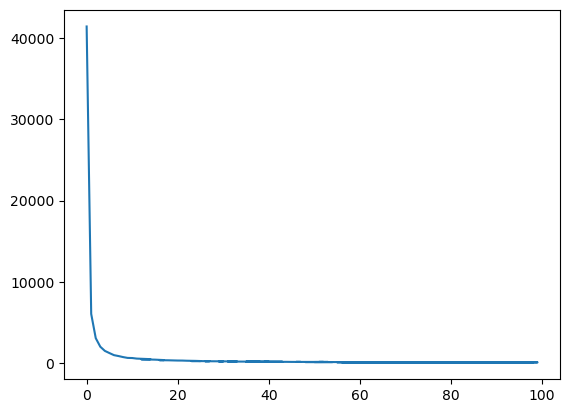

In [34]:
df_analysis['n_in_a_list'].value_counts().plot()

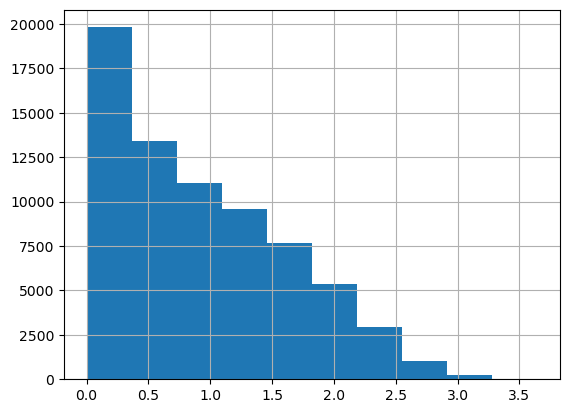

In [48]:
df_analysis['distance'].hist();

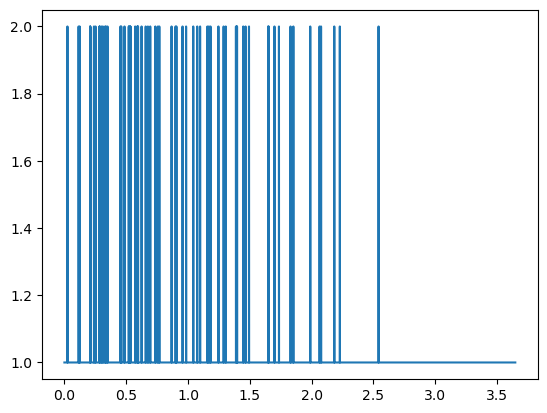

In [46]:
df_analysis['distance'].value_counts().sort_index().plot();

In [39]:
df_analysis.describe()

min      distance            max
count  1.000000e+05  71094.000000  100000.000000
mean   7.485738e-01      0.929236       2.190835
std    5.258498e-01      0.712142       0.581962
min    7.137672e-08      0.000013       0.015747
25%    3.219191e-01      0.314662       1.872633
50%    6.790525e-01      0.801730       2.286577
75%    1.095728e+00      1.437095       2.594149
max    2.893823e+00      3.647376       4.165978

In [35]:
type(base_index)

dict

In [43]:
df_for_cb = pd.DataFrame() 

# for i in range(2):
for i in range(df_train.shape[0]):
    df = pd.DataFrame(idx[i][:10])
    df = pd.concat([df, pd.DataFrame(vecs[i][:10])], axis=1)
    
    df.columns = ['idx', 'distance']
    df['query_idx'] = str(i) +'-query'
    df['target_idx'] = targets[i]
    df_for_cb = pd.concat([df_for_cb, df], ignore_index=True)
    

In [44]:
df_for_cb

idx  distance    query_idx    target_idx
0        598613  0.935593      0-query   675816-base
1       1934845  0.963717      0-query   675816-base
2        755584  0.975686      0-query   675816-base
3        450667  1.111225      0-query   675816-base
4         13374  1.160026      0-query   675816-base
...         ...       ...          ...           ...
999995   673739  2.018876  99999-query  2769109-base
999996   458565  2.136566  99999-query  2769109-base
999997   750263  2.211177  99999-query  2769109-base
999998  1737086  2.254107  99999-query  2769109-base
999999   947223  2.290553  99999-query  2769109-base

[1000000 rows x 4 columns]

In [45]:
def get_base_idx(row):
    return base_index[row['idx']]

In [46]:
df_for_cb['base_idx'] = df_for_cb.apply(get_base_idx, axis=1)
df_for_cb

idx  distance    query_idx    target_idx      base_idx
0        598613  0.935593      0-query   675816-base   675816-base
1       1934845  0.963717      0-query   675816-base  2725256-base
2        755584  0.975686      0-query   675816-base   877519-base
3        450667  1.111225      0-query   675816-base   494555-base
4         13374  1.160026      0-query   675816-base    13406-base
...         ...       ...          ...           ...           ...
999995   673739  2.018876  99999-query  2769109-base   771164-base
999996   458565  2.136566  99999-query  2769109-base   503996-base
999997   750263  2.211177  99999-query  2769109-base   870586-base
999998  1737086  2.254107  99999-query  2769109-base  2372472-base
999999   947223  2.290553  99999-query  2769109-base  1137584-base

[1000000 rows x 5 columns]

In [48]:
df_for_cb['target'] = df_for_cb['target_idx'] == df_for_cb['base_idx']
df_for_cb

idx  distance    query_idx    target_idx      base_idx  target
0        598613  0.935593      0-query   675816-base   675816-base    True
1       1934845  0.963717      0-query   675816-base  2725256-base   False
2        755584  0.975686      0-query   675816-base   877519-base   False
3        450667  1.111225      0-query   675816-base   494555-base   False
4         13374  1.160026      0-query   675816-base    13406-base   False
...         ...       ...          ...           ...           ...     ...
999995   673739  2.018876  99999-query  2769109-base   771164-base   False
999996   458565  2.136566  99999-query  2769109-base   503996-base   False
999997   750263  2.211177  99999-query  2769109-base   870586-base   False
999998  1737086  2.254107  99999-query  2769109-base  2372472-base   False
999999   947223  2.290553  99999-query  2769109-base  1137584-base   False

[1000000 rows x 6 columns]

In [50]:
df_for_cb['target'] = df_for_cb['target'].astype('int')

In [51]:
df_for_cb

idx  distance    query_idx    target_idx      base_idx  target
0        598613  0.935593      0-query   675816-base   675816-base       1
1       1934845  0.963717      0-query   675816-base  2725256-base       0
2        755584  0.975686      0-query   675816-base   877519-base       0
3        450667  1.111225      0-query   675816-base   494555-base       0
4         13374  1.160026      0-query   675816-base    13406-base       0
...         ...       ...          ...           ...           ...     ...
999995   673739  2.018876  99999-query  2769109-base   771164-base       0
999996   458565  2.136566  99999-query  2769109-base   503996-base       0
999997   750263  2.211177  99999-query  2769109-base   870586-base       0
999998  1737086  2.254107  99999-query  2769109-base  2372472-base       0
999999   947223  2.290553  99999-query  2769109-base  1137584-base       0

[1000000 rows x 6 columns]

In [52]:
df_for_cb = df_for_cb.merge(df_train, how='inner', left_on='query_idx', right_index=True)
df_for_cb

idx  distance    query_idx    target_idx      base_idx  target  \
0        598613  0.935593      0-query   675816-base   675816-base       1   
1       1934845  0.963717      0-query   675816-base  2725256-base       0   
2        755584  0.975686      0-query   675816-base   877519-base       0   
3        450667  1.111225      0-query   675816-base   494555-base       0   
4         13374  1.160026      0-query   675816-base    13406-base       0   
...         ...       ...          ...           ...           ...     ...   
999995   673739  2.018876  99999-query  2769109-base   771164-base       0   
999996   458565  2.136566  99999-query  2769109-base   503996-base       0   
999997   750263  2.211177  99999-query  2769109-base   870586-base       0   
999998  1737086  2.254107  99999-query  2769109-base  2372472-base       0   
999999   947223  2.290553  99999-query  2769109-base  1137584-base       0   

               0         1         2         3  ...        62        63  \
0       0.239281  0.368604  0.008569 -0.350583  ... -0.168177  0.253033   
1       0.239281  0.368604  0.008569 -0.350583  ... -0.168177  0.253033   
2       0.239281  0.368604  0.008569 -0.350583  ... -0.168177  0.253033   
3       0.239281  0.368604  0.008569 -0.350583  ... -0.168177  0.253033   
4       0.239281  0.368604  0.008569 -0.350583  ... -0.168177  0.253033   
...          ...       ...       ...       ...  ...       ...       ...   
999995 -0.020837  0.107609 -0.047345  0.024419  ... -0.017776 -0.211124   
999996 -0.020837  0.107609 -0.047345  0.024419  ... -0.017776 -0.211124   
999997 -0.020837  0.107609 -0.047345  0.024419  ... -0.017776 -0.211124   
999998 -0.020837  0.107609 -0.047345  0.024419  ... -0.017776 -0.211124   
999999 -0.020837  0.107609 -0.047345  0.024419  ... -0.017776 -0.211124   

              64        65        66        67        68        69        70  \
0      -0.008581 -0.337892 -0.196293  0.038266 -0.037421  0.169316  0.554073   
1      -0.008581 -0.337892 -0.196293  0.038266 -0.037421  0.169316  0.554073   
2      -0.008581 -0.337892 -0.196293  0.038266 -0.037421  0.169316  0.554073   
3      -0.008581 -0.337892 -0.196293  0.038266 -0.037421  0.169316  0.554073   
4      -0.008581 -0.337892 -0.196293  0.038266 -0.037421  0.169316  0.554073   
...          ...       ...       ...       ...       ...       ...       ...   
999995  0.090204 -0.270478 -0.095533  0.076950  0.167680 -0.138854  0.867139   
999996  0.090204 -0.270478 -0.095533  0.076950  0.167680 -0.138854  0.867139   
999997  0.090204 -0.270478 -0.095533  0.076950  0.167680 -0.138854  0.867139   
999998  0.090204 -0.270478 -0.095533  0.076950  0.167680 -0.138854  0.867139   
999999  0.090204 -0.270478 -0.095533  0.076950  0.167680 -0.138854  0.867139   

              71  
0       0.101823  
1       0.101823  
2       0.101823  
3       0.101823  
4       0.101823  
...          ...  
999995 -0.141987  
999996 -0.141987  
999997 -0.141987  
999998 -0.141987  
999999 -0.141987  

[1000000 rows x 78 columns]

In [53]:
df_for_cb = df_for_cb.merge(df_base, how='inner', left_on='base_idx', right_index=True)

In [54]:
df_for_cb

idx  distance    query_idx    target_idx      base_idx  target  \
0        598613  0.935593      0-query   675816-base   675816-base       1   
1       1934845  0.963717      0-query   675816-base  2725256-base       0   
9015    1934845  2.014728    901-query   161242-base  2725256-base       0   
289077  1934845  1.476375  28907-query   674092-base  2725256-base       0   
567248  1934845  0.956052  56724-query   503871-base  2725256-base       0   
...         ...       ...          ...           ...           ...     ...   
999991  1831967  1.671472  99999-query  2769109-base  2539368-base       0   
999994   594554  1.984267  99999-query  2769109-base   670754-base       0   
999996   458565  2.136566  99999-query  2769109-base   503996-base       0   
999997   750263  2.211177  99999-query  2769109-base   870586-base       0   
999998  1737086  2.254107  99999-query  2769109-base  2372472-base       0   

             0_x       1_x       2_x       3_x  ...      62_y      63_y  \
0       0.239281  0.368604  0.008569 -0.350583  ... -0.179609  0.326034   
1       0.239281  0.368604  0.008569 -0.350583  ... -0.101116  0.418121   
9015    0.352969  0.213540 -0.042794 -0.245692  ... -0.101116  0.418121   
289077  0.096556  0.424952  0.061261 -0.313913  ... -0.101116  0.418121   
567248  0.117892  0.320004 -0.015379 -0.347744  ... -0.101116  0.418121   
...          ...       ...       ...       ...  ...       ...       ...   
999991 -0.020837  0.107609 -0.047345  0.024419  ... -0.032370 -0.179900   
999994 -0.020837  0.107609 -0.047345  0.024419  ...  0.023709 -0.253076   
999996 -0.020837  0.107609 -0.047345  0.024419  ... -0.196060 -0.329466   
999997 -0.020837  0.107609 -0.047345  0.024419  ...  0.087396 -0.233007   
999998 -0.020837  0.107609 -0.047345  0.024419  ...  0.027143 -0.042061   

            64_y      65_y      66_y      67_y      68_y      69_y      70_y  \
0       0.010284  0.124374 -0.095380  0.076162 -0.106079  0.008652  0.554073   
1      -0.073709 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363   
9015   -0.073709 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363   
289077 -0.073709 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363   
567248 -0.073709 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363   
...          ...       ...       ...       ...       ...       ...       ...   
999991  0.127189 -0.258958  0.013384  0.180111  0.163031  0.200031  0.913121   
999994  0.084580 -0.419252  0.154866 -0.019108  0.097573 -0.243122  0.924937   
999996  0.290073 -0.088791 -0.141275 -0.045135  0.166958 -0.471007  0.872271   
999997 -0.223924 -0.005834 -0.006287 -0.154689 -0.107312 -0.022844  0.602969   
999998  0.230607  0.116505 -0.145585 -0.165248  0.035308  0.255069  0.812712   

            71_y  
0       0.136746  
1       0.160391  
9015    0.160391  
289077  0.160391  
567248  0.160391  
...          ...  
999991 -0.136804  
999994 -0.271919  
999996 -0.079540  
999997 -0.039050  
999998 -0.142870  

[1000000 rows x 150 columns]

# Catboost

In [58]:
cb_features = df_for_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx', 'target'], axis=1)
cb_features

distance       0_x       1_x       2_x       3_x       4_x       5_x  \
0       0.935593  0.239281  0.368604  0.008569 -0.350583  0.306816 -0.097762   
1       0.963717  0.239281  0.368604  0.008569 -0.350583  0.306816 -0.097762   
9015    2.014728  0.352969  0.213540 -0.042794 -0.245692 -0.038643 -0.049236   
289077  1.476375  0.096556  0.424952  0.061261 -0.313913  0.317086 -0.124524   
567248  0.956052  0.117892  0.320004 -0.015379 -0.347744  0.167770  0.055894   
...          ...       ...       ...       ...       ...       ...       ...   
999991  1.671472 -0.020837  0.107609 -0.047345  0.024419  0.128058 -0.094803   
999994  1.984267 -0.020837  0.107609 -0.047345  0.024419  0.128058 -0.094803   
999996  2.136566 -0.020837  0.107609 -0.047345  0.024419  0.128058 -0.094803   
999997  2.211177 -0.020837  0.107609 -0.047345  0.024419  0.128058 -0.094803   
999998  2.254107 -0.020837  0.107609 -0.047345  0.024419  0.128058 -0.094803   

             6_x       7_x       8_x  ...      62_y      63_y      64_y  \
0       0.083055  0.050857 -0.439529  ... -0.179609  0.326034  0.010284   
1       0.083055  0.050857 -0.439529  ... -0.101116  0.418121 -0.073709   
9015   -0.355018  0.063079 -0.174506  ... -0.101116  0.418121 -0.073709   
289077 -0.390290 -0.021014 -0.357263  ... -0.101116  0.418121 -0.073709   
567248 -0.005781  0.100447 -0.230036  ... -0.101116  0.418121 -0.073709   
...          ...       ...       ...  ...       ...       ...       ...   
999991  0.379774  0.163937 -0.176410  ... -0.032370 -0.179900  0.127189   
999994  0.379774  0.163937 -0.176410  ...  0.023709 -0.253076  0.084580   
999996  0.379774  0.163937 -0.176410  ... -0.196060 -0.329466  0.290073   
999997  0.379774  0.163937 -0.176410  ...  0.087396 -0.233007 -0.223924   
999998  0.379774  0.163937 -0.176410  ...  0.027143 -0.042061  0.230607   

            65_y      66_y      67_y      68_y      69_y      70_y      71_y  
0       0.124374 -0.095380  0.076162 -0.106079  0.008652  0.554073  0.136746  
1      -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363  0.160391  
9015   -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363  0.160391  
289077 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363  0.160391  
567248 -0.095984 -0.226508  0.030397 -0.237002 -0.002731  0.868363  0.160391  
...          ...       ...       ...       ...       ...       ...       ...  
999991 -0.258958  0.013384  0.180111  0.163031  0.200031  0.913121 -0.136804  
999994 -0.419252  0.154866 -0.019108  0.097573 -0.243122  0.924937 -0.271919  
999996 -0.088791 -0.141275 -0.045135  0.166958 -0.471007  0.872271 -0.079540  
999997 -0.005834 -0.006287 -0.154689 -0.107312 -0.022844  0.602969 -0.039050  
999998  0.116505 -0.145585 -0.165248  0.035308  0.255069  0.812712 -0.142870  

[1000000 rows x 145 columns]

In [61]:
cb_target = df_for_cb['target']
cb_target.value_counts() / cb_target.shape[0]

0    0.941676
1    0.058324
Name: target, dtype: float64

In [66]:
cbc = CatBoostClassifier(auto_class_weights = 'Balanced', verbose=10)

In [67]:
cbc.fit(cb_features, cb_target)

Learning rate set to 0.196759
0:	learn: 0.6200217	total: 157ms	remaining: 2m 37s
10:	learn: 0.4188554	total: 1.62s	remaining: 2m 25s
20:	learn: 0.3525499	total: 2.97s	remaining: 2m 18s
30:	learn: 0.3093449	total: 4.36s	remaining: 2m 16s
40:	learn: 0.2829361	total: 5.78s	remaining: 2m 15s
50:	learn: 0.2669711	total: 7.18s	remaining: 2m 13s
60:	learn: 0.2505012	total: 8.6s	remaining: 2m 12s
70:	learn: 0.2393353	total: 10.1s	remaining: 2m 11s
80:	learn: 0.2319026	total: 11.4s	remaining: 2m 9s
90:	learn: 0.2242581	total: 12.8s	remaining: 2m 8s
100:	learn: 0.2167748	total: 14.2s	remaining: 2m 6s
110:	learn: 0.2104296	total: 15.5s	remaining: 2m 4s
120:	learn: 0.2057226	total: 16.9s	remaining: 2m 2s
130:	learn: 0.2022733	total: 18.2s	remaining: 2m
140:	learn: 0.1987924	total: 19.5s	remaining: 1m 58s
150:	learn: 0.1950733	total: 20.8s	remaining: 1m 57s
160:	learn: 0.1900627	total: 22.1s	remaining: 1m 55s
170:	learn: 0.1843825	total: 23.5s	remaining: 1m 53s
180:	learn: 0.1819017	total: 24.8s	re

# validation search

In [69]:
start_time = dt.datetime.now().timestamp()
val_vecs, val_idx = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), 100)
time_spent = dt.datetime.now().timestamp() - start_time
time_spent

2438.1331191062927

In [70]:
validation_answer = pd.read_csv("datasets/validation_answer.csv", index_col=0)
validation_answer.head()

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

In [72]:
acc = 0
for target, el in zip(validation_answer.values.tolist(), val_idx.tolist()):
    acc += int(target[0] in [base_index[r] for r in el])

print(100 * acc / len(idx))

71.017


In [73]:
val_df_for_cb = pd.DataFrame() 

for i in range(2):
# for i in range(df_validation.shape[0]):
    df = pd.DataFrame(val_idx[i][:10])
    df = pd.concat([df, pd.DataFrame(val_vecs[i][:10])], axis=1)
    
    df.columns = ['idx', 'distance']
    df['query_idx'] = str(100000+i) +'-query'
    df['target_idx'] = validation_answer[i]
    val_df_for_cb = pd.concat([val_df_for_cb, df], ignore_index=True)

KeyError: 0